# Plotting cell types associated with Hassall's

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import anndata
import warnings 
import scipy.stats
from collections import Counter
import os
warnings.filterwarnings('ignore')
import statsmodels.api as sm

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # to show output from all the lines in a cells
pd.set_option('display.max_column',None) # display all the columns in pandas
pd.options.display.max_rows = 100

sc.logging.print_header()
import matplotlib.pyplot as plt
sc.settings.set_figure_params(dpi = 200, color_map = 'RdYlBu_r', dpi_save = 300, format = 'pdf',fontsize=12)
plt.rcParams["figure.figsize"] = [6,6]
import matplotlib.pyplot as plt 
from matplotlib import font_manager 
font_manager.fontManager.addfont("") 
print(font_manager.findfont("Arial")) 
plt.rcParams["font.sans-serif"] = ["Arial"] 
plt.rcParams["pdf.fonttype"] = 42

In [31]:
sc.settings.set_figure_params(dpi = 150, color_map = 'RdYlBu_r', dpi_save = 300, format = 'pdf',fontsize=12)

In [3]:
source_folder = ''

In [4]:
adata_paed = sc.read_h5ad('')

In [5]:
adata_paed.shape
#filter spots by coverage
adata_paed_filt = adata_paed[adata_paed.obs['tot_cell_abundance']>25,:].copy()
adata_paed_filt.shape
adata_paed_filt = adata_paed_filt[adata_paed_filt.obs['n_genes_by_counts']>1000,:].copy()
adata_paed_filt.shape
adata_paed_filt = adata_paed_filt[((adata_paed_filt.obs['annotations_level_1']!= "fat")&
                                (adata_paed_filt.obs['annotations_level_0']!="Artifacts")),:].copy()
adata_paed_filt.shape

(38245, 36601)

(34252, 36601)

(29708, 36601)

(25740, 36601)

In [6]:
adata_paed_filt = adata_paed_filt[~adata_paed_filt.obs['annotations_level_0'].isna(),:].copy()
adata_paed_filt.shape

(25576, 36601)

In [7]:
adata_paed_filt.shape

(25576, 36601)

In [8]:
adata_paed_cma = adata_paed_filt.copy()
adata_paed_cma.shape

## remove meduala less lobules 
adata_paed_cma.obs['full_lobule'] = 0
for s in adata_paed_cma.obs['SampleID'].cat.categories.tolist():
    sample = adata_paed_cma[adata_paed_cma.obs['SampleID'].isin([s])]
    for l in sample.obs['annotations_lobules_0'].cat.categories:
        lobule = sample.obs['annotations_lobules_0'] == l
        med = np.where(sample.obs['annotations_level_0'][lobule] == 'Medulla')[0]
        cortex = np.where(sample.obs['annotations_level_0'][lobule] == 'Cortex')[0]
        if (cortex.size>=3) & (med.size>=3):
            adata_paed_cma.obs['full_lobule'][lobule.iloc[np.where(lobule)].index] = 1
adata_paed_cma.obs['full_lobule'] = adata_paed_cma.obs['full_lobule'].astype('category')
adata_paed_cma.obs['full_lobule'].value_counts()
adata_paed_cma = adata_paed_cma[adata_paed_cma.obs['full_lobule']==1]# remove spots that don't have either medullar or cortical data
adata_paed_cma.shape

(25576, 36601)

1    22805
0     2771
Name: full_lobule, dtype: int64

(22805, 36601)

In [9]:
adata_paed_hc = adata_paed_cma.copy()

### Cell type analysis (Visium)

In [10]:
celltypes = adata_paed_cma.uns['mod']['factor_names']
cellab_paed_hc = sc.AnnData(adata_paed_cma.obs[celltypes], 
                         obs = adata_paed_cma.obs.drop(celltypes, axis = 1),obsm = adata_paed_cma.obsm)
cellab_paed_hc.layers['raw_abn'] = cellab_paed_hc.X.copy()
sc.pp.normalize_total(cellab_paed_hc,target_sum=100)

cellab_paed_hc = cellab_paed_hc[(cellab_paed_hc.obs['cma_v2']>0.1) &
                                (cellab_paed_hc.obs['L2_dist_annotations_level_1_HS']<=175),:].copy()

In [11]:
# version 3 hybrid
def mean_space(adata_vis,anno,threshold = 0.5,minspots=25,exp=True):
    space_map = {}
    for c in adata_vis.var_names:
        cells_above = np.where(adata_vis.X[:,np.where(adata_vis.var_names==c)]>threshold)[0]
        if len(cells_above)>minspots:
            obs_ind = np.where(adata_vis.obs.columns == anno)[0]
            cell_abn = np.squeeze(adata_vis.X[cells_above,np.where(adata_vis.var_names==c)])                      
            axis_value =  np.squeeze(np.array(adata_vis.obs.iloc[cells_above,obs_ind]))
            if exp:
                temp = np.dot(cell_abn,axis_value)/np.sum(cell_abn)-0.13
                space_map[c] = np.sign(temp)*np.power(temp,2)
            else:
                space_map[c] = (np.dot(cell_abn,axis_value)/np.sum(cell_abn))
    return space_map

In [12]:
space_map_cma = mean_space(cellab_paed_hc,'cma_v2',threshold=2.5,minspots=10, exp=False)
for i in space_map_cma:
    space_map_cma[i] = space_map_cma[i]
    if space_map_cma[i]<0.1:
        space_map_cma[i] = None # remove cells that are not medullar centered  

space_map_hc = mean_space(cellab_paed_hc,'L2_dist_annotations_level_1_HS',threshold=2.5,minspots=10,exp=False)  
for i in space_map_hc:
    space_map_hc[i] = space_map_hc[i]*2 # correct back to linear and micron distance ppm=0.5 hence the 2 
    space_map_hc[i] = space_map_hc[i] # correct back to linear and micron distance ppm=0.5 hence the 2 
    if not space_map_cma[i]:
        space_map_hc[i] = None # remove cells that are not medullar centered  

In [13]:
df_vis = pd.DataFrame.from_dict({'space_map_cma': space_map_cma, 'space_map_hc': space_map_hc}, orient='index').T.dropna()

In [17]:
# source_folder

In [18]:
df_vis.sort_values(['space_map_hc']).to_csv (f'{source_folder}/HC_vs_CMA_ctype_abundance.csv')

In [19]:
df_vis.sort_values(['space_map_hc']).iloc[0:15]

,space_map_cma,space_map_hc
TEC-cilliated,0.698373,51.135353
mTECIII,0.638952,62.90974
mTECI-trans,0.679367,104.92171
mTECII,0.63197,121.677703
TEC-neuro,0.597845,130.085119
TEC-myo,0.650531,146.502327
pDC,0.597301,148.340457
T_Treg-diff_2,0.673812,148.436573
B-naive,0.669069,149.871298
aDC1,0.608287,155.566431


Text(0.5, 0, 'CMA')

Text(0, 0.5, 'Distance to Hassall(μm)')

(0.4, 0.75)

(0.0, 350.0)

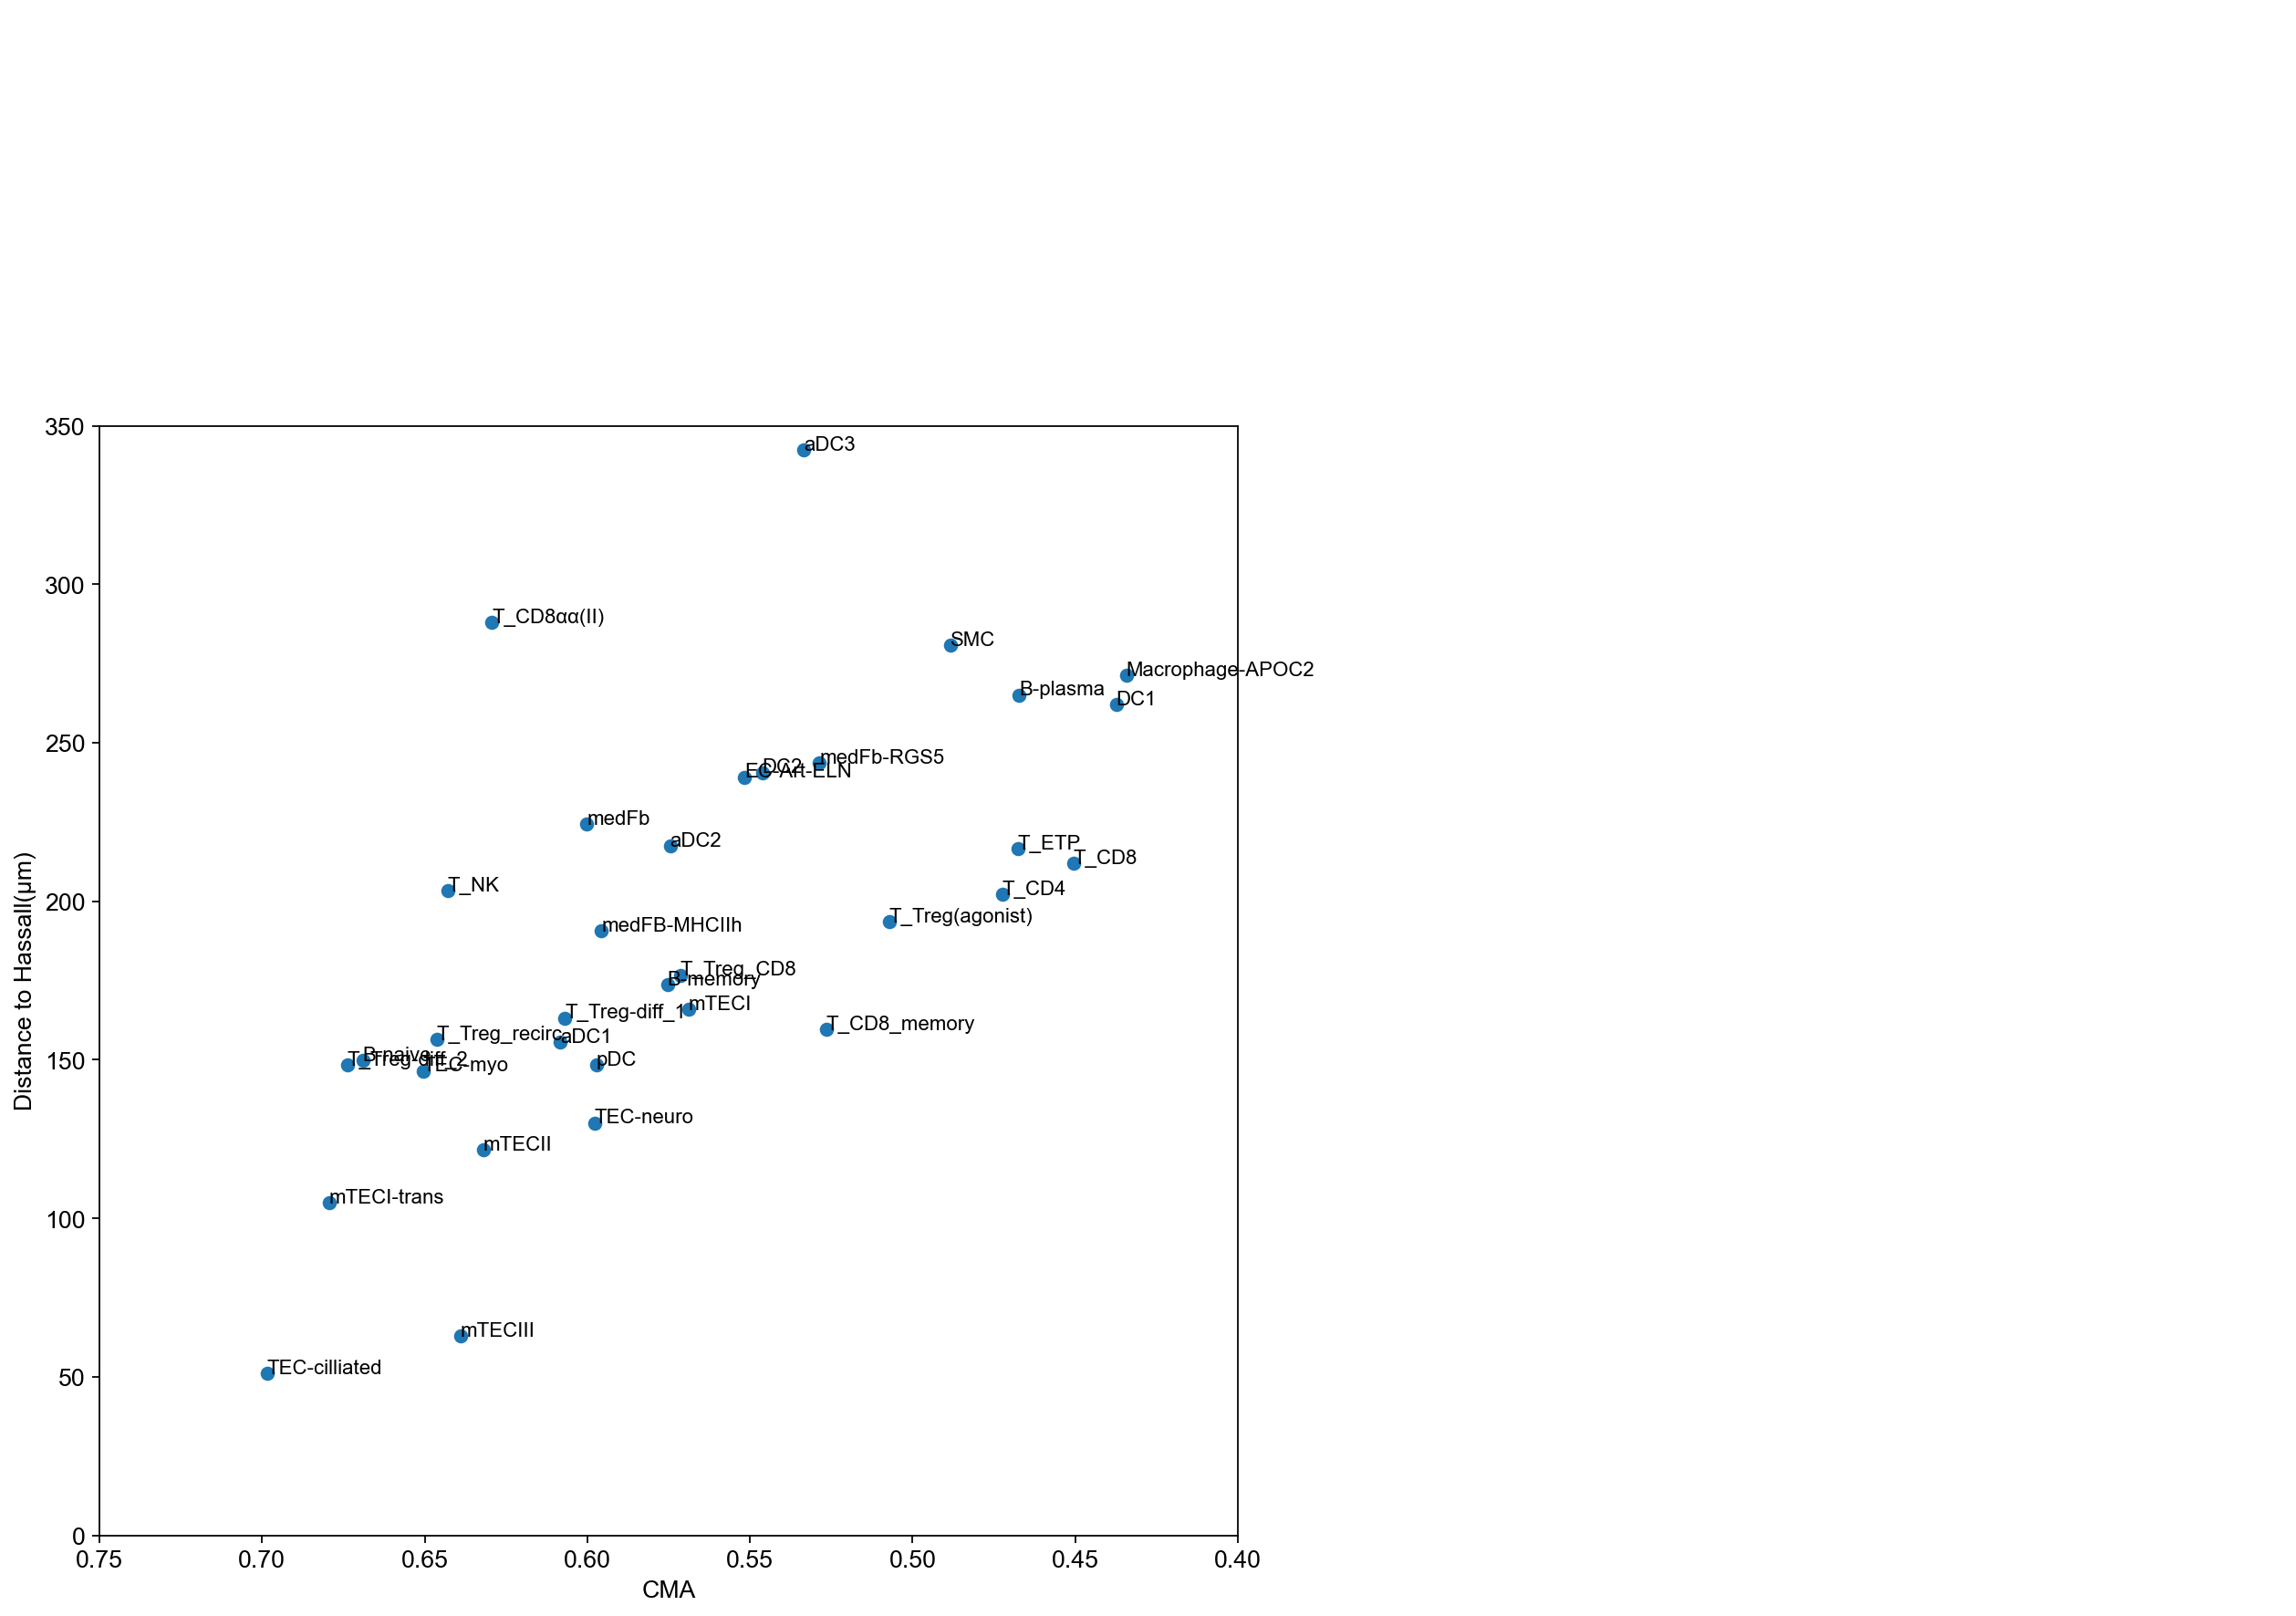

In [15]:
# plot the scatter plot
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
# from adjustText import adjust_text
# plot the scatter plot
sc.set_figure_params(figsize=[10,10],fontsize=12)
# Fit a polynomial of degree 1 robust (linear fit)
x = np.array(df_vis['space_map_cma']).astype('float32')
y = np.array(df_vis['space_map_hc']).astype('float32')

# Fit a robust regression model

# Plot the data points
plt.scatter(x, y, label='Data')

# Plot the robust regression line
#plt.plot(x, results.predict(sm.add_constant(x)), color='red', label='Robust Regression')
# add labels for each point
#for i, label in enumerate(df_vis.index):
#    plt.annotate(label, (df_vis['space_map_cma'][i]+0.00005, df_vis['space_map_hc'][i]))
texts = [plt.annotate(label, (df_vis['space_map_cma'][i]+0.00005, df_vis['space_map_hc'][i]),fontsize=10) for i, label in enumerate(df_vis.index)]
#adjust_text(texts)
# add axis labels
plt.xlabel('CMA')
plt.ylabel("Distance to Hassall(μm)")
plt.grid(False)
#plt.legend()
plt.xlim([0.4, 0.75])
plt.ylim([0, 350])
plt.gca().invert_xaxis()
plt.savefig('')
plt.show()

## Plot Hassall's body associations

In [22]:
celltypes = adata_paed_cma.uns['mod']['factor_names']
cellab_paed_hc = sc.AnnData(adata_paed_cma.obs[celltypes], 
                         obs = adata_paed_cma.obs.drop(celltypes, axis = 1),obsm = adata_paed_cma.obsm)
cellab_paed_hc.layers['raw_abn'] = cellab_paed_hc.X.copy()
sc.pp.normalize_total(cellab_paed_hc,target_sum=100)

In [23]:
cellab_paed_hc.obs['Hassal_dist'] = cellab_paed_hc.obs['L2_dist_annotations_level_1_HS']*2 # correct to microns

cellab_paed_hc = cellab_paed_hc[(cellab_paed_hc.obs['cma_v2']>0.12) &
                                (cellab_paed_hc.obs['L2_dist_annotations_level_1_HS']<=350),:].copy()

cellab_paed_hc.obs['Hassal_rad'] = pd.cut(cellab_paed_hc.obs['Hassal_dist'],
                                         bins = range(0, 375, 25), include_lowest = True)

cellab_paed_hc.obs['Hassal_rad2'] = cellab_paed_hc.obs['Hassal_rad'].copy()
cellab_paed_hc.obs['Hassal_rad2'] = cellab_paed_hc.obs['Hassal_rad2'].astype(str)

cellab_paed_hc.obs.loc[cellab_paed_hc.obs['annotations_level_1'] == "HS",'Hassal_rad2'] = 'Hassal_body'

cellab_paed_hc.obs['Hassal_rad2'] = cellab_paed_hc.obs['Hassal_rad2'].astype('category')
cellab_paed_hc = cellab_paed_hc[cellab_paed_hc.obs['Hassal_rad2'] != 'nan']

new_cats = ['Hassal_body', '(-0.001, 25.0]', '(25.0, 50.0]', '(50.0, 75.0]', '(75.0, 100.0]', '(100.0, 125.0]', '(125.0, 150.0]',
            '(150.0, 175.0]', '(175.0, 200.0]', '(200.0, 225.0]', '(225.0, 250.0]', '(250.0, 275.0]', '(275.0, 300.0]', '(300.0, 325.0]','(325.0, 350.0]']

cellab_paed_hc.obs['Hassal_rad2'].cat.reorder_categories (new_cats, inplace = True)


intervals = []
for i in range(0, 350, 25):
    intervals.append(f"{i}-{i+25} μm rad")

cellab_paed_hc.obs['Hassal_rad2'].cat.categories = ['Hassal_body']+intervals

In [24]:
cellab_paed_hc

View of AnnData object with n_obs × n_vars = 6596 × 63
    obs: 'Sample', 'Sample_hr', 'SampleID', 'SlideID', 'Position', 'in_tissue', 'array_row', 'array_col', 'x', 'y', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'percent_mito', 'annotations_level_0', 'annotations_level_0_number', 'annotations_level_1', 'annotations_level_1_number', 'annotations_lobules_0', 'annotations_lobules_0_number', 'L2_dist_annotations_level_0_Artifacts', 'L2_dist_annotations_level_0_Cortex', 'L2_dist_annotations_level_0_Edge', 'L2_dist_annotations_level_0_Medulla', 'L2_dist_annotations_level_1_HS', 'L2_dist_annotations_level_1_PVS', 'L2_dist_annotations_level_1_fat', 'L2_dist_annotations_level_1_vessels', 'L2_dist_annotations_level_0_lymph', 'L2_dist_annotations_level_1_unassigned', 'cm', 'cc', 'cma_v2', 'manual_bin_cma_v2', 'manual_bin_cma_v2_int', 'Image_name', 'Image_jpg', 'section_thickness (um)', 'permebialisation(min)', 'RIN/DV200', 'Visium_type', 'Funding', 'Se

In [25]:
hc_ctypes = df_vis.index.tolist()
adata_paed_hc_prox = cellab_paed_hc.copy()
adata_paed_hc_prox.X[adata_paed_hc_prox.X<0.05] = 0

In [26]:
ctypes_ordered = df_vis.sort_values(['space_map_hc']).index.tolist()[0:25]

In [27]:
len(ctypes_ordered)

25

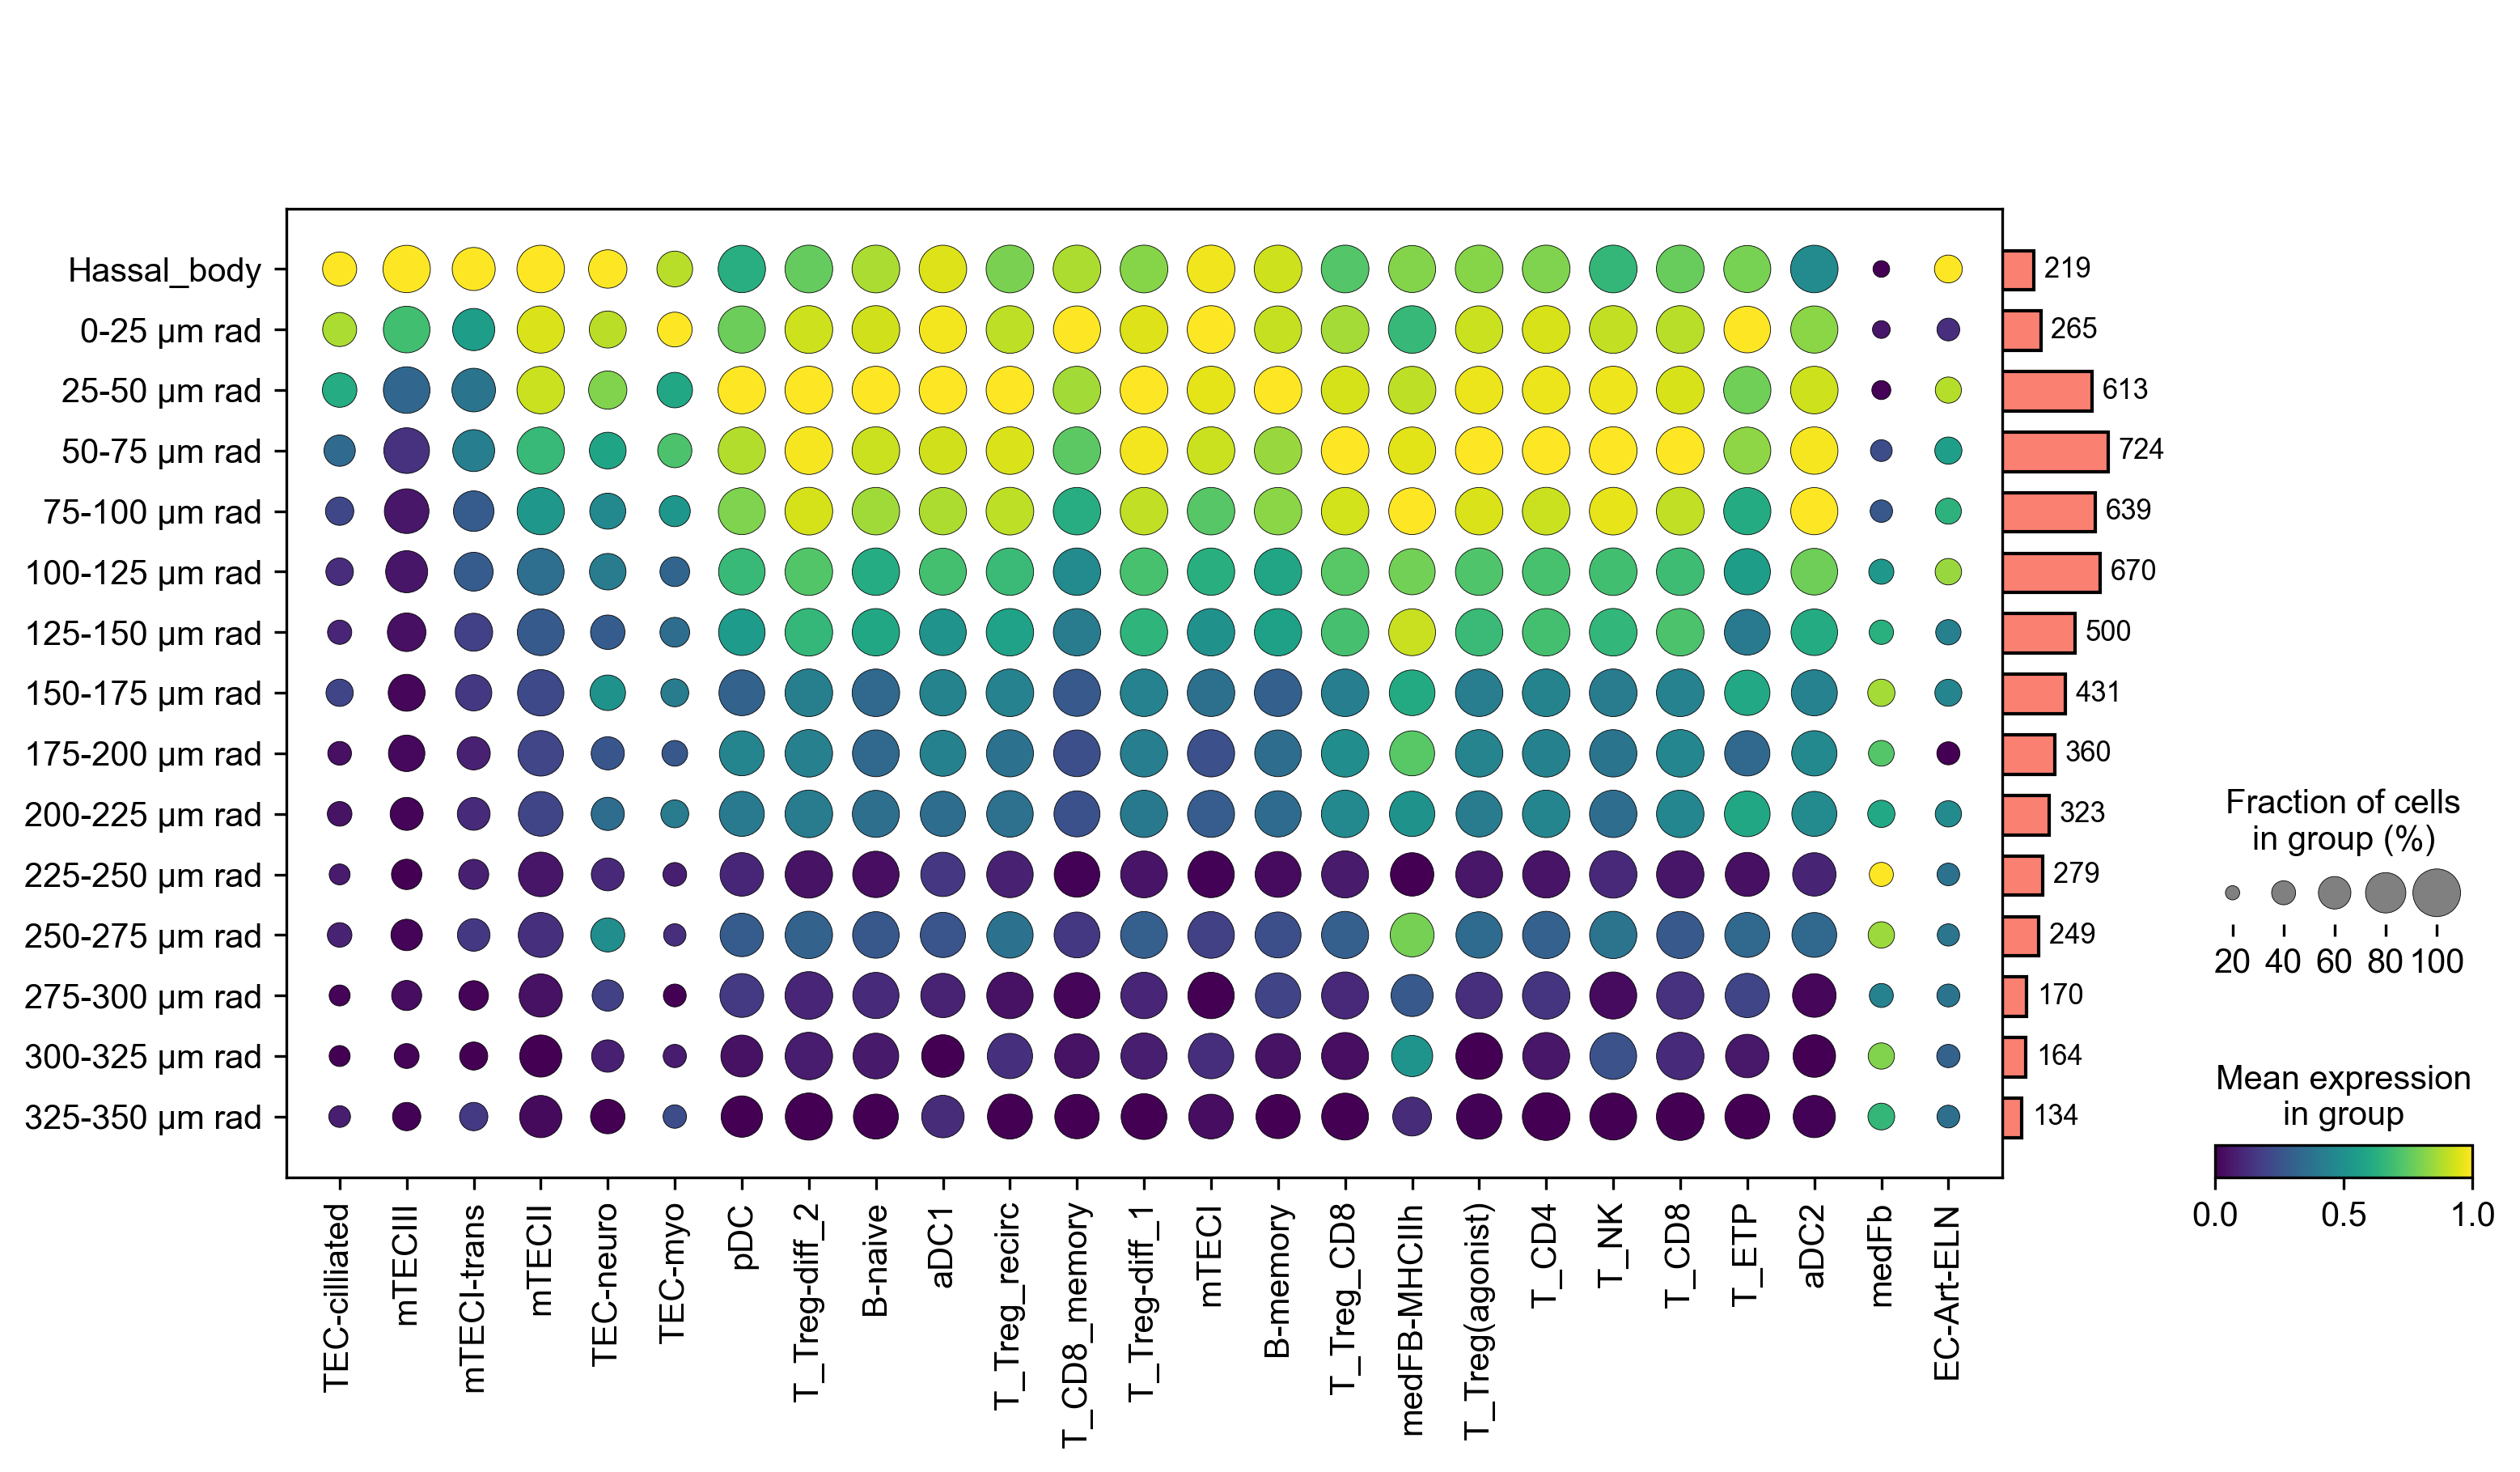

In [32]:
dp = sc.pl.dotplot(adata_paed_hc_prox, var_names = ctypes_ordered, groupby = 'Hassal_rad2',  
                   cmap = 'viridis', standard_scale = "var", return_fig=True)
dp.add_totals()
#dp.savefig('figures/HC_bins_ctype_associations_dotplot_norm_subset.pdf')
dp.show()

In [34]:
def export_Source_dotplot (Dotplot_obj, path, name):
    title1 = pd.DataFrame(['Cell type abundance (scaled across radii)'], columns=['Title'])
    df1 = Dotplot_obj.dot_color_df
    title2 = pd.DataFrame(['Percentage of spots'], columns=['Title'])
    df2 = Dotplot_obj.dot_size_df
    # Create an Excel writer object
    with pd.ExcelWriter(f'{path}/{name}.xlsx', engine='openpyxl') as writer:
        # Write the first title
        title1.to_excel(writer, index=False, header=False, startrow=0, sheet_name='Sheet1')
        # Write the first dataframe
        df1.to_excel(writer, startrow=1, sheet_name='Sheet1')
        # Calculate the row to start the second title
        startrow = len(df1) + 3  # Adding 4 rows for spacer and title
        # Write the second title
        title2.to_excel(writer, index=False, header=False, startrow=startrow, sheet_name='Sheet1')
        # Write the second dataframe
        df2.to_excel(writer, startrow=startrow+1, sheet_name='Sheet1')
        print (f'{path}/{name}.xlsx has been written')

In [35]:
export_Source_dotplot (dp, path = source_folder, name = "HC_radii_ctype_abudance")